# News Recommender System

This a Google Colab for our project for the AI Course at UCU, 2021.

**Authors**: Dmytro Lopushanskyy, Volodymyr Savchuk.

The report for this project will be attached separately on CMS.

Here is a list of materials that helped us create this project:

* [MIND Data set](https://msnews.github.io/)
* [Build Recommendation Engine](https://realpython.com/build-recommendation-engine-collaborative-filtering/)
* [Recommender Systems in Python](https://www.kaggle.com/gspmoreira/recommender-systems-in-python-101#Recommender-Systems-in-Python-101)
* [MIND Recommendation Notebook](https://www.kaggle.com/accountstatus/mind-microsoft-news-recommendation-v2/notebook#Text-Preprocessing)
* [Evaluating Recommender Systems](http://fastml.com/evaluating-recommender-systems/)

## Imports

In [ ]:
import numpy as np
import scipy
import pandas as pd
import math
import random
import sklearn
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import plotly.express as px
from wordcloud import WordCloud
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

## Load The Data

We are using MIND data set for our recommendation system. It contains two main files: behaviors and English news articles data.

In [ ]:
behaviors_header = ['ImpressionID', 'UserID', 'Time', 'History', 'Impressions']
behaviors_df = pd.read_csv('/content/drive/MyDrive/Data/behaviors.tsv', sep='\t', names=behaviors_header)
test_behaviors_df = pd.read_csv('/content/drive/MyDrive/Data/test_behaviors.tsv', sep='\t', names=behaviors_header)

news_header = ['NewsID', 'Category', 'SubCategory', 'Title', 'Abstract', 'URL', 'TitleEntities', 'AbstractEntities']
articles_df = pd.read_csv('/content/drive/MyDrive/Data/news.tsv', sep='\t', names=news_header)
test_articles_df = pd.read_csv('/content/drive/MyDrive/Data/test_news.tsv', sep='\t', names=news_header)

# articles_df += test_articles_df

behaviors_df.head(5)

,ImpressionID,UserID,Time,History,Impressions
0,1,U13740,11/11/2019 9:05:58 AM,N55189 N42782 N34694 N45794 N18445 N63302 N104...,N55689-1 N35729-0
1,2,U91836,11/12/2019 6:11:30 PM,N31739 N6072 N63045 N23979 N35656 N43353 N8129...,N20678-0 N39317-0 N58114-0 N20495-0 N42977-0 N...
2,3,U73700,11/14/2019 7:01:48 AM,N10732 N25792 N7563 N21087 N41087 N5445 N60384...,N50014-0 N23877-0 N35389-0 N49712-0 N16844-0 N...
3,4,U34670,11/11/2019 5:28:05 AM,N45729 N2203 N871 N53880 N41375 N43142 N33013 ...,N35729-0 N33632-0 N49685-1 N27581-0
4,5,U8125,11/12/2019 4:11:21 PM,N10078 N56514 N14904 N33740,N39985-0 N36050-0 N16096-0 N8400-1 N22407-0 N6...


In [ ]:
articles_df.head()

,NewsID,Category,SubCategory,Title,Abstract,URL,TitleEntities,AbstractEntities
0,N55528,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",https://assets.msn.com/labs/mind/AAGH0ET.html,"[{""Label"": ""Prince Philip, Duke of Edinburgh"",...",[]
1,N19639,health,weightloss,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...,https://assets.msn.com/labs/mind/AAB19MK.html,"[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik...","[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik..."
2,N61837,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...,https://assets.msn.com/labs/mind/AAJgNsz.html,[],"[{""Label"": ""Ukraine"", ""Type"": ""G"", ""WikidataId..."
3,N53526,health,voices,I Was An NBA Wife. Here's How It Affected My M...,"I felt like I was a fraud, and being an NBA wi...",https://assets.msn.com/labs/mind/AACk2N6.html,[],"[{""Label"": ""National Basketball Association"", ..."
4,N38324,health,medical,"How to Get Rid of Skin Tags, According to a De...","They seem harmless, but there's a very good re...",https://assets.msn.com/labs/mind/AAAKEkt.html,"[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI...","[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI..."


Filter from NA values and from users who have a small click history (less than 5)

In [ ]:
filtered_behaviors = behaviors_df[behaviors_df.History.str.split().str.len() > 5]

f"Number of rows before: {behaviors_df.shape[0]}. After: {filtered_behaviors.shape[0]}"


'Number of rows before: 156965. After: 130019'

In [ ]:
# Drop articles with duplicate titles
filtered_articles = articles_df.drop_duplicates(subset=['Title'])

# Drop articles with empty Abstract
filtered_articles = filtered_articles[filtered_articles.Abstract.notna()]

# Drop articles with titles less than 4 words
filtered_articles = filtered_articles[filtered_articles['Title'].apply((lambda x: len(x.split())>=4))]

f"Number of rows before: {articles_df.shape[0]}. After: {filtered_articles.shape[0]}"


'Number of rows before: 51282. After: 47661'

In [ ]:
filtered_articles.head()

,NewsID,Category,SubCategory,Title,Abstract,URL,TitleEntities,AbstractEntities
0,N55528,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",https://assets.msn.com/labs/mind/AAGH0ET.html,"[{""Label"": ""Prince Philip, Duke of Edinburgh"",...",[]
1,N19639,health,weightloss,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...,https://assets.msn.com/labs/mind/AAB19MK.html,"[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik...","[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik..."
2,N61837,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...,https://assets.msn.com/labs/mind/AAJgNsz.html,[],"[{""Label"": ""Ukraine"", ""Type"": ""G"", ""WikidataId..."
3,N53526,health,voices,I Was An NBA Wife. Here's How It Affected My M...,"I felt like I was a fraud, and being an NBA wi...",https://assets.msn.com/labs/mind/AACk2N6.html,[],"[{""Label"": ""National Basketball Association"", ..."
4,N38324,health,medical,"How to Get Rid of Skin Tags, According to a De...","They seem harmless, but there's a very good re...",https://assets.msn.com/labs/mind/AAAKEkt.html,"[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI...","[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI..."


## Exploratory Data Analysis

In [ ]:
filtered_articles = filtered_articles.iloc[:,:5]
filtered_articles.head()

,NewsID,Category,SubCategory,Title,Abstract
0,N55528,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the..."
1,N19639,health,weightloss,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...
2,N61837,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...
3,N53526,health,voices,I Was An NBA Wife. Here's How It Affected My M...,"I felt like I was a fraud, and being an NBA wi..."
4,N38324,health,medical,"How to Get Rid of Skin Tags, According to a De...","They seem harmless, but there's a very good re..."


In [ ]:
behaviors_df_expanded = behaviors_df.copy()

In [ ]:
behaviors_df_expanded['Number of Articles interacted'] = behaviors_df['History'].str.split(' ').str.len()
behaviors_df_expanded['Number of Articles showed'] = behaviors_df['Impressions'].str.split(' ').str.len()

### Distributions

In [ ]:
num_of_articles = behaviors_df_expanded['Number of Articles interacted']
num_of_articles.describe()

count    153727.000000
mean         33.225387
std          40.408679
min           1.000000
25%           8.000000
50%          20.000000
75%          43.000000
max         558.000000
Name: Number of Articles interacted, dtype: float64

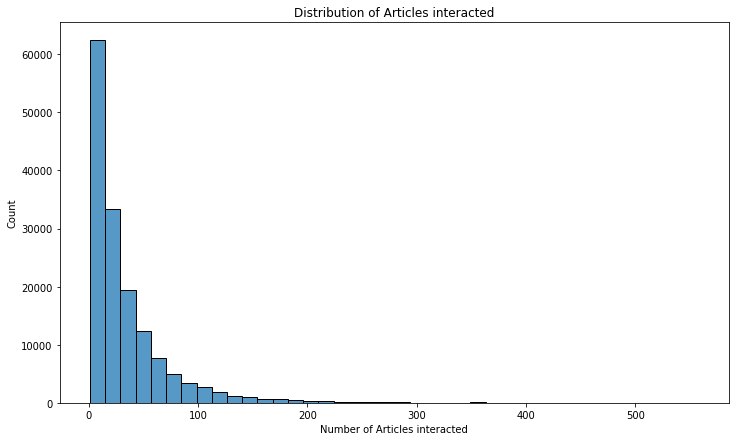

In [ ]:
fig = plt.figure(figsize=(12, 7))
sns.histplot(num_of_articles, bins=40)
plt.title("Distribution of Articles interacted")
plt.show()

In [ ]:
num_of_articles = behaviors_df_expanded['Number of Articles showed']
num_of_articles.describe()

count    156965.000000
mean         37.227688
std          38.594148
min           2.000000
25%          10.000000
50%          24.000000
75%          51.000000
max         299.000000
Name: Number of Articles showed, dtype: float64

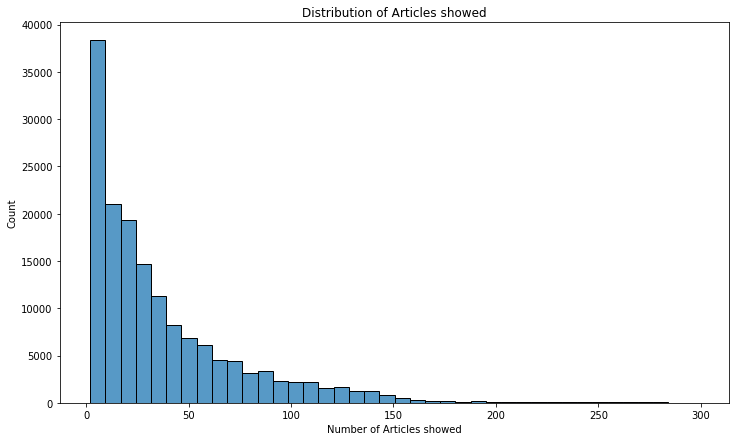

In [ ]:
fig = plt.figure(figsize=(12, 7))
sns.histplot(num_of_articles, bins=40)
plt.title("Distribution of Articles showed")
plt.show()

### Category distribution

In [ ]:
c = filtered_articles[['Category','SubCategory']].value_counts()

In [ ]:
index=[]
for i in c.index:
    index.append(np.array(i))
index=np.array(index)

In [ ]:
df=pd.DataFrame(columns=['Category','Sub Category','Values'])
df['Category']=index[:,0]
df['Sub Category']=index[:,1]
df['Values']=c.values

In [ ]:
px.bar(data_frame=df,x='Category',y='Values',color='Sub Category')

From this plot we see that the most of the news was on the Category of news with subcategory newsus followed by sports with football news.

### WordCloud For Sports News

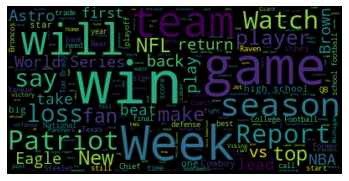

In [ ]:
text=' '
for i in filtered_articles[filtered_articles['Category']=='sports']['Title']:
    text+=i+' '
    
# Make the figure
wordcloud = WordCloud().generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")

plt.show()

### Wordcloud for news

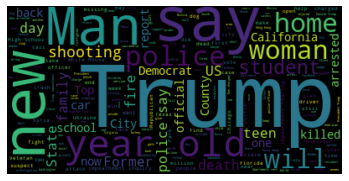

In [ ]:
text=' '
for i in filtered_articles[filtered_articles['Category']=='news']['Title']:
    text+=i+' '
    
# Make the figure
wordcloud = WordCloud().generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")

plt.show()

In [ ]:
filtered_articles.isna().sum()

NewsID         0
Category       0
SubCategory    0
Title          0
Abstract       0
dtype: int64

In [ ]:
titles = []
for title in filtered_articles['Title']:
    titles.append(len(title))
px.histogram(titles, color=filtered_articles['Category'])

TypeError: ignored

### Category distribution

In [ ]:
c = filtered_articles[['Category','SubCategory']].value_counts()

In [ ]:
index=[]
for i in c.index:
    index.append(np.array(i))
index=np.array(index)

In [ ]:
df=pd.DataFrame(columns=['Category','Sub Category','Values'])
df['Category']=index[:,0]
df['Sub Category']=index[:,1]
df['Values']=c.values

In [ ]:
px.bar(data_frame=df,x='Category',y='Values',color='Sub Category')

## Text Preprocessing

In [ ]:
# This function is to remove stopwords from a particular column and to tokenize it
def rem_stopwords_tokenize(data,name):
      
    def getting(sen):
        example_sent = sen

        stop_words = set(stopwords.words('english')) 

        word_tokens = word_tokenize(example_sent) 

        filtered_sentence = [w for w in word_tokens if not w in stop_words] 

        filtered_sentence = [] 

        for w in word_tokens: 
            if w not in stop_words: 
                filtered_sentence.append(w) 
        return filtered_sentence
    x=[]
    for i in data[name].values:
        x.append(getting(i))
    data[name]=x

In [ ]:
# Making a function to lemmatize all the words
lemmatizer = WordNetLemmatizer() 
def lemmatize_all(data,name):
    arr = data[name]
    a = []
    for i in arr:
        b = []
        for j in i:
            x = lemmatizer.lemmatize(j,pos='a')
            x = lemmatizer.lemmatize(x)
            b.append(x)
        a.append(b)
    data[name] = a

In [ ]:
def convert_to_string(data, name):
    t = data[name].values
    p = []
    for i in t:
        listToStr = ' '.join(map(str, i))
        p.append(listToStr)
    data[name] = p

In [ ]:
# Removing Stop words from Title Column
rem_stopwords_tokenize(filtered_articles, 'Title')

# Lemmatizing the Title column
lemmatize_all(filtered_articles, 'Title')

# Back to string
convert_to_string(filtered_articles, 'Title')

In [ ]:
# Removing Stop words from Abstract Column
rem_stopwords_tokenize(filtered_articles, 'Abstract')

# Lemmatizing the Abstract column
lemmatize_all(filtered_articles, 'Abstract')

# Back to string
convert_to_string(filtered_articles, 'Abstract')

## Split into train and test data sets

In [ ]:
filtered_behaviors.set_index('UserID')
filtered_behaviors['All_History'] = filtered_behaviors.groupby(['UserID']).History.transform(lambda x: ' '.join(x)).transform(lambda x: list(set(x.split())))

In [ ]:
all_history = filtered_behaviors.drop_duplicates(subset=['UserID'])
all_history = all_history.filter(['UserID', 'All_History'])
all_history = all_history.set_index('UserID')
all_history

In [ ]:
expanded_behaviors = all_history.explode('All_History').reset_index() 
expanded_behaviors.rename(columns={'All_History': 'NewsID'}, inplace=True)

In [ ]:
behaviours_train_df, behaviours_test_df = train_test_split(expanded_behaviors,
                                   stratify=expanded_behaviors['UserID'], 
                                   test_size=0.20,
                                   random_state=42)

print('# interactions on Train set: %d' % len(behaviours_train_df))
print('# interactions on Test set: %d' % len(behaviours_test_df))

In [ ]:
# Indexing by UserID to speed up the searches during evaluation
behaviours_full_indexed_df = expanded_behaviors.set_index('UserID')
behaviours_train_indexed_df = behaviours_train_df.set_index('UserID')
behaviours_test_indexed_df = behaviours_test_df.set_index('UserID')

In [ ]:
# group by userID back to aggregated values
history_train_indexed_df = behaviours_train_indexed_df.groupby(['UserID'])['NewsID'].apply(list).reset_index().set_index('UserID')
history_train_indexed_df.rename(columns={'NewsID': 'All_History'}, inplace=True)

history_test_indexed_df = behaviours_test_indexed_df.groupby(['UserID'])['NewsID'].apply(list).reset_index().set_index('UserID')
history_test_indexed_df.rename(columns={'NewsID': 'All_History'}, inplace=True)

In [ ]:
history_train_indexed_df.index.values

In [ ]:
# implement filtering
history_test_indexed_df = history_test_indexed_df[history_test_indexed_df.index.isin(history_train_indexed_df.index.values.tolist())]
behaviours_test_indexed_df = behaviours_test_indexed_df[behaviours_test_indexed_df.index.isin(history_train_indexed_df.index.values.tolist())]

In [ ]:
print('Full size: ', behaviours_full_indexed_df.size)
print('Train size: ', behaviours_train_indexed_df.size)
print('Test size: ', behaviours_test_indexed_df.size)

## Content-Based Filtering model

Create a vectorizer on behaviours train dataset

In [ ]:
# Ignoring stopwords (words with no semantics) from English
stopwords_list = stopwords.words('english')

# Trains a model whose vectors size is 5000, composed by the main unigrams and bigrams found in the corpus, ignoring stopwords
vectorizer = TfidfVectorizer(analyzer='word',
                     ngram_range=(1, 2),
                     min_df=0.003,
                     max_df=0.5,
                     max_features=5000,
                     stop_words=stopwords_list)

item_ids = filtered_articles['NewsID'].tolist()
tfidf_matrix = vectorizer.fit_transform(filtered_articles['Title'] + "" + filtered_articles['Abstract'])
tfidf_feature_names = vectorizer.get_feature_names()
tfidf_matrix


In [ ]:
def get_item_profile(item_id):
    # get a single item feature list by ID
    try:
        idx = item_ids.index(item_id)
    except:
        return None
    item_profile = tfidf_matrix[idx:idx+1]
    return item_profile

def get_item_profiles(ids):
    # get item vector given all item IDs that user clicked
    item_profiles_list = [get_item_profile(x) for x in ids if x]
    item_profiles = scipy.sparse.vstack(item_profiles_list)
    return item_profiles

def build_users_profile(person_id, interactions_df):
    # build feature vector for a single user

    # aggregate all news a user has clicked
    interactions_person_df = interactions_df.loc[person_id]
    user_item_profiles = get_item_profiles(interactions_person_df['All_History'])

    # print("user_item_profiles", user_item_profiles)
    if user_item_profiles.shape[1] == 0:
      return None
    user_item_strengths = np.array([1] * user_item_profiles.shape[1])
    # Weighted average of item profiles by the interactions strength
    user_item_strengths_weighted_avg = np.sum(user_item_profiles.multiply(user_item_strengths), axis=0) / np.sum(user_item_strengths)
    user_profile_norm = sklearn.preprocessing.normalize(user_item_strengths_weighted_avg)
    return user_profile_norm


def build_users_profiles(): 
    # build a global martix of features for all users on TRAIN data set

    user_profiles = {}
    for person_id in history_train_indexed_df.index.unique():
        user_profile = build_users_profile(person_id, history_train_indexed_df)
        if user_profile is not None:
            user_profiles[person_id] = user_profile
        else:
            print(f"No data for user {person_id}")
    return user_profiles


In [ ]:
user_profiles = build_users_profiles()

In [ ]:
len(user_profiles)

In [ ]:
my_user_id = 'U13740'

myprofile = user_profiles[my_user_id]
print(myprofile.shape)
pd.DataFrame(sorted(zip(tfidf_feature_names, 
                        user_profiles[my_user_id].flatten().tolist()), key=lambda x: -x[1])[:20],
             columns=['token', 'relevance'])

In [ ]:
class ContentBasedRecommender:
    MODEL_NAME = 'Content-Based'
    
    def __init__(self, items_df=None):
        self.item_ids = item_ids
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def _get_similar_items_to_user_profile(self, person_id, topn=1000):
        # Computes the cosine similarity between the user profile and all item profiles
        cosine_similarities = cosine_similarity(user_profiles[person_id], tfidf_matrix)
        # Gets the top similar items
        similar_indices = cosine_similarities.argsort().flatten()[-topn:]
        # Sort the similar items by similarity
        similar_items = sorted([(item_ids[i], cosine_similarities[0,i]) for i in similar_indices], key=lambda x: -x[1])
        return similar_items
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, ignore_interacted=True, verbose=False):
        similar_items = self._get_similar_items_to_user_profile(user_id, topn)
        # Ignores items the user has already interacted
        if ignore_interacted:
            similar_items = list(filter(lambda x: x[0] not in items_to_ignore, similar_items))
        
        recommendations_df = pd.DataFrame(similar_items, columns=['NewsID', 'recStrength']) \
                                    .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'contentId', 
                                                          right_on = 'contentId')[['recStrength', 'contentId', 'title', 'url', 'lang']]


        return recommendations_df
    
content_based_recommender_model = ContentBasedRecommender(articles_df)

### Recommendations for a single user

In [ ]:
recs = content_based_recommender_model.recommend_items(my_user_id)
recs.set_index('NewsID')
pd.merge(recs, filtered_articles)

## Evaluation Class

In [ ]:
def get_items_interacted(person_id, interactions_df):
    # Get the user's data and merge in the news information.
    interacted_items = interactions_df.loc[person_id]['NewsID']
    return set(interacted_items if type(interacted_items) == pd.Series else [interacted_items])

In [ ]:
filtered_articles.shape

In [ ]:
# Top-N accuracy metrics consts
EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS = 100

class ModelEvaluator:
    def get_not_interacted_items_sample(self, person_id, sample_size, seed=42):
        interacted_items = get_items_interacted(person_id, behaviours_full_indexed_df)
        all_items = set(filtered_articles['NewsID'])
        non_interacted_items = all_items - interacted_items

        random.seed(seed)
        non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
        return set(non_interacted_items_sample)

    def _verify_hit_top_n(self, item_id, recommended_items, topn):      
        try:
            index = next(i for i, c in enumerate(recommended_items) if c == item_id)
        except Exception as e:
            index = -1
        hit = int(index in range(0, topn))
        return hit, index

    def evaluate_model_for_user(self, model, person_id):
        # Getting the items in test set
        interacted_values_testset = behaviours_test_indexed_df.loc[person_id]
        if type(interacted_values_testset['NewsID']) == pd.Series:
            person_interacted_items_testset = set(interacted_values_testset['NewsID'])
        else:
            person_interacted_items_testset = set([interacted_values_testset['NewsID']])  
        interacted_items_count_testset = len(person_interacted_items_testset) 

        # Getting a ranked recommendation list from a model for a given user
        person_recs_df = model.recommend_items(
            person_id, 
            items_to_ignore=get_items_interacted(person_id, behaviours_train_indexed_df), 
            topn=10000000000, ignore_interacted=False)
        
        hits_at_5_count = 0
        hits_at_10_count = 0
        # For each item the user has interacted in test set
        for item_id in person_interacted_items_testset:
            # Getting a random sample (100) items the user has not interacted 
            # (to represent items that are assumed to be no relevant to the user)
            non_interacted_items_sample = self.get_not_interacted_items_sample(person_id, 
                                                                          sample_size=EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS, 
                                                                          seed=random.randint(0, 2**32))

            # Combining the current interacted item with the 100 random items
            items_to_filter_recs = non_interacted_items_sample.union(set([item_id]))

            # Filtering only recommendations that are either the interacted item or from a random sample of 100 non-interacted items
            valid_recs_df = person_recs_df[person_recs_df['NewsID'].isin(items_to_filter_recs)]                    
            valid_recs = valid_recs_df['NewsID'].values
            # Verifying if the current interacted item is among the Top-N recommended items
            hit_at_5, index_at_5 = self._verify_hit_top_n(item_id, valid_recs, 5)
            hits_at_5_count += hit_at_5
            hit_at_10, index_at_10 = self._verify_hit_top_n(item_id, valid_recs, 10)
            hits_at_10_count += hit_at_10

        # Recall is the rate of the interacted items that are ranked among the Top-N recommended items, 
        # when mixed with a set of non-relevant items
        recall_at_5 = hits_at_5_count / float(interacted_items_count_testset)
        recall_at_10 = hits_at_10_count / float(interacted_items_count_testset)

        person_metrics = {'hits@5_count': hits_at_5_count, 
                          'hits@10_count': hits_at_10_count, 
                          'interacted_count': interacted_items_count_testset,
                          'recall@5': recall_at_5,
                          'recall@10': recall_at_10}
        return person_metrics

    def evaluate_model(self, model):
        print('Running evaluation for users')
        people_metrics = []
        for idx, person_id in enumerate(list(behaviours_test_indexed_df.index.unique().values)):
            if idx % 100 == 0 and idx > 0:
               print('%d users processed' % idx)
            person_metrics = self.evaluate_model_for_user(model, person_id)  
            person_metrics['_person_id'] = person_id
            people_metrics.append(person_metrics)
        print('%d users processed' % idx)

        detailed_results_df = pd.DataFrame(people_metrics) \
                            .sort_values('interacted_count', ascending=False)
        
        global_recall_at_5 = detailed_results_df['hits@5_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        global_recall_at_10 = detailed_results_df['hits@10_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        
        global_metrics = {'modelName': model.get_model_name(),
                          'recall@5': global_recall_at_5,
                          'recall@10': global_recall_at_10}    
        return global_metrics, detailed_results_df
    
model_evaluator = ModelEvaluator()    

Reduce the test data set to 3000 elements to reduce computation time

In [ ]:
behaviours_test_indexed_df_full = behaviours_test_indexed_df.copy()
behaviours_test_indexed_df = behaviours_test_indexed_df[:3000]

In [ ]:
len(set(behaviours_test_indexed_df.index.values.tolist()))
behaviours_test_indexed_df.shape

In [ ]:
print('Evaluating Content-Based Filtering model...')
cb_global_metrics, cb_detailed_results_df = model_evaluator.evaluate_model(content_based_recommender_model)

In [ ]:
print('\nGlobal metrics:\n%s' % cb_global_metrics)
cb_detailed_results_df.sort_values('recall@10', ascending=False).head(20)

# Collaborative Filtering

We need to take all of the news articles available to us and the train behaviours dataset.

Since CF is taking quite a lot of memory, we will start by using 100 users and all articles.

In [ ]:
LIMIT = 100
limited_users = history_train_indexed_df.index[:100]

ratings_df = pd.DataFrame(data=0, columns=filtered_articles.NewsID, index=limited_users)

for i in range(LIMIT):
    user_history = history_train_indexed_df.iloc[i].tolist()[0]
    for news_id in user_history:
        ratings_df.iloc[i][news_id] = 1

In [ ]:
ratings_df

In [ ]:
from sklearn.neighbors import NearestNeighbors

knn = NearestNeighbors(metric='cosine', algorithm='brute')
knn.fit(ratings_df.values)
distances, indices = knn.kneighbors(ratings_df.values, n_neighbors=10)

In [ ]:
# get the index for user
index_for_user = ratings_df.index.tolist().index('U100')

# find the indices for the similar users
sim_users = indices[index_for_user].tolist()

# distances between user and the similar users
user_distances = distances[index_for_user].tolist()

# the position of user in the list sim_users
id_user = sim_users.index(index_for_user)

# remove user from the list sim_users
sim_users.remove(index_for_user)

# remove user from the list user_distances
user_distances.pop(id_user)

print('The Nearest Users to U100:', sim_users)
print('The Distance from U100:', user_distances)

In [ ]:
len(filtered_articles.NewsID)

In [ ]:
def augment_rating_df(ratings):
    augmented_ratings = ratings.copy()

    # find the nearest neighbors using NearestNeighbors(n_neighbors=10)
    number_neighbors = 10
    knn = NearestNeighbors(metric='cosine', algorithm='brute')
    knn.fit(ratings.values)
    distances, indices = knn.kneighbors(ratings.values, n_neighbors=number_neighbors)

    for news_id in filtered_articles.NewsID[:1000]:
        news_index = filtered_articles.NewsID.tolist().index(news_id)

        for user_loc, user_id in list(enumerate(ratings.index)):
            # find news without ratings by user
            if ratings.iloc[user_loc, news_index] == 0:
                sim_users = indices[user_loc].tolist()
                users_distances = distances[user_loc].tolist()
                
                # Generally, this is the case. The user itself is in the first place.
                if user_id in sim_users:
                    user_idx = sim_users.index(user_id)
                    sim_users.remove(user_id)
                    users_distances.pop(user_idx) 

                # However, sometimes even the movie itself cannot be included in the indices.
                # In that case, we take off the farthest movie in the list.
                else:
                    sim_users = sim_users[:number_neighbors - 1]
                    users_distances = users_distances[:number_neighbors - 1]
                    
                # user_similarity = 1 - users_distances
                user_similarity = [1 - x for x in users_distances]
                user_similarity_copy = user_similarity.copy()
                nominator = 0

                # for each similar user
                for i in range(len(sim_users)):
                    # check if the rating of a similar news is zero
                    if ratings.iloc[sim_users[i], news_index] == 0:
                        # if the rating is zero, ignore the rating and the similarity in calculating the predicted rating
                        if len(user_similarity_copy) == (number_neighbors - 1):
                            user_similarity_copy.pop(i)
                        else:
                            user_similarity_copy.pop(i - (len(user_similarity) - len(user_similarity_copy)))

                    # if the rating is not zero, use the rating and similarity in the calculation
                    else:
                        nominator += user_similarity[i] * ratings.iloc[sim_users[i], news_index]

                # check if the number of the ratings with non-zero is positive
                if len(user_similarity_copy) > 0:
                    # check if the sum of the ratings of the similar movies is positive.
                    if sum(user_similarity_copy) > 0:
                        predicted_r = nominator / sum(user_similarity_copy)

                    # Even if there are some news for which the ratings are positive, some movies have zero similarity even though they are selected as similar movies.
                    # in this case, the predicted rating becomes zero as well  
                    else:
                        predicted_r = 0

                # if all the ratings of the similar news are zero, then predicted rating should be zero
                else:
                    predicted_r = 0

                # place the predicted rating into the augmented original dataset
                augmented_ratings.iloc[user_loc, news_index] = predicted_r
    return augmented_ratings
            

In [ ]:
augmented_ratings_user_based = augment_rating_df(ratings_df)
augmented_ratings_user_based

In [ ]:
augmented_ratings_item_based = augment_rating_df(ratings_df.T)
augmented_ratings_item_based

In [ ]:
def recommend_news(user, num_recommended_news):
    print('The list of the News {} Has Clicked on \n'.format(user))

    for news_id in ratings_df.loc[user, :][ratings_df.loc[user, :] > 0].index.tolist():
        print(news_id)
    
    print('\n')

    recommended_news = []

    for news_id in ratings_df.loc[user, :][ratings_df.loc[user, :] == 0].index.tolist():
        predicted_rating = augmented_ratings.loc[user, news_id]
        recommended_news.append((news_id, predicted_rating))

    sorted_rm = sorted(recommended_news, key=lambda x: x[1], reverse=True)
    
    print('The list of the Recommended News \n')
    rank = 1
    for recommended_news in sorted_rm[:num_recommended_news]:
        print('{}: {} - predicted rating:{}'.format(rank, recommended_news[0], recommended_news[1]))
        rank = rank + 1

In [ ]:
recommend_news('U10003', 10)

In [ ]:
# Top-N accuracy metrics consts
EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS = 100

class ModelEvaluatorCF:
    def get_not_interacted_items_sample(self, person_id, sample_size, seed=42):
        interacted_items = get_items_interacted(person_id, behaviours_full_indexed_df)
        all_items = set(filtered_articles['NewsID'])
        non_interacted_items = all_items - interacted_items

        random.seed(seed)
        non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
        return set(non_interacted_items_sample)

    def _verify_hit_top_n(self, item_id, recommended_items, topn):      
        try:
            index = next(i for i, c in enumerate(recommended_items) if c == item_id)
        except Exception as e:
            index = -1
        hit = int(index in range(0, topn))
        return hit, index

    def evaluate_model_for_user(self, model, person_id):
        # Getting the items in test set
        interacted_values_testset = behaviours_test_indexed_df.loc[person_id]
        if type(interacted_values_testset['NewsID']) == pd.Series:
            person_interacted_items_testset = set(interacted_values_testset['NewsID'])
        else:
            person_interacted_items_testset = set([interacted_values_testset['NewsID']])  
        interacted_items_count_testset = len(person_interacted_items_testset) 

        # Getting a ranked recommendation list from a model for a given user
        person_recs_df = model.recommend_items(
            person_id, 
            items_to_ignore=get_items_interacted(person_id, behaviours_train_indexed_df), 
            topn=10000000000, ignore_interacted=False)
        
        hits_at_5_count = 0
        hits_at_10_count = 0
        # For each item the user has interacted in test set
        for item_id in person_interacted_items_testset:
            # Getting a random sample (100) items the user has not interacted 
            # (to represent items that are assumed to be no relevant to the user)
            non_interacted_items_sample = self.get_not_interacted_items_sample(person_id, 
                                                                          sample_size=EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS, 
                                                                          seed=random.randint(0, 2**32))

            # Combining the current interacted item with the 100 random items
            items_to_filter_recs = non_interacted_items_sample.union(set([item_id]))

            # Filtering only recommendations that are either the interacted item or from a random sample of 100 non-interacted items
            valid_recs_df = person_recs_df[person_recs_df['NewsID'].isin(items_to_filter_recs)]                    
            valid_recs = valid_recs_df['NewsID'].values
            # Verifying if the current interacted item is among the Top-N recommended items
            hit_at_5, index_at_5 = self._verify_hit_top_n(item_id, valid_recs, 5)
            hits_at_5_count += hit_at_5
            hit_at_10, index_at_10 = self._verify_hit_top_n(item_id, valid_recs, 10)
            hits_at_10_count += hit_at_10

        # Recall is the rate of the interacted items that are ranked among the Top-N recommended items, 
        # when mixed with a set of non-relevant items
        recall_at_5 = hits_at_5_count / float(interacted_items_count_testset)
        recall_at_10 = hits_at_10_count / float(interacted_items_count_testset)

        person_metrics = {'hits@5_count': hits_at_5_count, 
                          'hits@10_count': hits_at_10_count, 
                          'interacted_count': interacted_items_count_testset,
                          'recall@5': recall_at_5,
                          'recall@10': recall_at_10}
        return person_metrics

    def evaluate_model(self, model):
        print('Running evaluation for users')
        people_metrics = []
        for idx, person_id in enumerate(list(behaviours_test_indexed_df.index.unique().values)):
            if idx % 100 == 0 and idx > 0:
               print('%d users processed' % idx)
            person_metrics = self.evaluate_model_for_user(model, person_id)  
            person_metrics['_person_id'] = person_id
            people_metrics.append(person_metrics)
        print('%d users processed' % idx)

        detailed_results_df = pd.DataFrame(people_metrics) \
                            .sort_values('interacted_count', ascending=False)
        
        global_recall_at_5 = detailed_results_df['hits@5_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        global_recall_at_10 = detailed_results_df['hits@10_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        
        global_metrics = {'modelName': model.get_model_name(),
                          'recall@5': global_recall_at_5,
                          'recall@10': global_recall_at_10}    
        return global_metrics, detailed_results_df
    
model_evaluator = ModelEvaluator()    